In [1]:
import sys
sys.path.append('d:/flagellar/code/core')
sys.path.append('/flagellar/code/core/')
sys.path.append('/kaggle/input/my-flagellar-library/')
import flg_support as fls
import flg_runner
import importlib
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os
import itertools
import glob
import dataclasses
import pandas as pd
import statsmodels.api as sm
import ISLP
import ISLP.models
import subprocess
import io

predict_all = False

MainProcess


In [2]:
# Prepare datasets
if predict_all:
     res_dir = fls.result_dir + '/many_abbr_full/'
#     fls.download_kaggle_dataset('jeroencottaar/byu-many-models/', res_dir)
else:
     res_dir = fls.result_dir + '/many_abbr_res/'
     #fls.download_kaggle_dataset('jeroencottaar/byu-many-models-abbreviated/', res_dir)

In [3]:
# Read results from vast.ai
files = glob.glob(res_dir + '*.pickle')
dicts = []
dicts_kaggle_comp = []
modifier_values_list = []
data_list = []
missing_values = dict()
for f in files:    
    if not '900' in f and not '628' in f:
        continue
    print(f)
    data_list.append(fls.dill_load(f)    )
    #if not (data_list[-1].modifier_values['seed']>=5): print('skip'); continue
    modifier_values_list.append(data_list[-1].modifier_values)
    #print(modifier_values_list[-1])
    for key,value in data_list[-1].modifier_dict.items():
        missing_values[key] = value.missing_value
    #print(modifier_values_list[-1])

for data, modifier_values in zip(data_list, modifier_values_list):

    d = copy.deepcopy(missing_values)
    #print(modifier_values)
    for key,value in modifier_values.items():
        d[key] = value
        #print(d)
    d['lr0_times_nepochs'] = d['lr0']*d['n_epochs']
    #print(d)
    #raise 'stop'
    if predict_all:
        data.trained_model.data_after_step2 = data.inferred_test_data     
        data.trained_model.step3Output.threshold=-1
        data.inferred_test_data = data.trained_model.infer(data.test_data)
        
    d['label'] = data.label
    d['git_commit_id'] = data.git_commit_id
    d['use_missing_value'] = data.use_missing_value
    d['cv_score'] = fls.score_competition_metric(data.inferred_test_data, data.test_data)[2]

    d_kaggle_comp = dict()
    d_kaggle_comp['label'] = data.label
    d_kaggle_comp['git_commit_id'] = d['git_commit_id']
    d_kaggle_comp['use_missing_value'] = d['use_missing_value']
    d_kaggle_comp['seed'] = d['seed']   
    d_kaggle_comp['cv_score'] = d['cv_score']
    d_kaggle_comp['k_score'] = np.nan

    print(len(data.test_data))

    dicts_kaggle_comp.append(d_kaggle_comp)

    # First set
    #if not (d['seed']<26 or d['use_missing_value']): print('skip'); continue

    # New
    #if not (d['seed']>=26 or d['use_missing_value']): print('skip'); continue
    #if d['label']=='Test ensemble': continue
    
    
    for partial in fls.DataSelector().datasets:
        data_selector = fls.DataSelector()
        data_selector.datasets = [partial]
        d['cv_score_' + partial] = fls.score_competition_metric(data_selector.select(data.inferred_test_data), data_selector.select(data.test_data))[2]
    d['k_score']= np.nan

    dicts.append(d)    
p = pd.DataFrame(dicts)
p.sort_values(['seed', 'git_commit_id'], inplace=True);

p_kaggle_comp = pd.DataFrame(dicts_kaggle_comp)
p_kaggle_comp.sort_values(['seed', 'git_commit_id'], inplace=True);

# First set
# p = p[np.logical_or(p['seed']<26, p['use_missing_value'])]

# New
#p = p[np.logical_or(p['seed']>=26, p['use_missing_value'])]

p = p.reset_index()
p_kaggle_comp = p_kaggle_comp.reset_index()

d:/flagellar/results//many_abbr_res\Baseline_0_900b54ed_610 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_10_900b54ed_556 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_11_900b54ed_577 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_12_900b54ed_572 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_13_900b54ed_544 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_14_900b54ed_649 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_15_900b54ed_538 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_16_900b54ed_530 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_17_900b54ed_542 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_18_900b54ed_567 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_19_6287bd7b_566 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_1_900b54ed_555 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_20_6287bd7b_529 _a.pickle
d:/flagellar/results//many_abbr_res\Baseline_21_6287bd7b_585 _a.pickle
d:/flage

In [4]:
# Load Kaggle results
if predict_all:
    kaggle_results_file = fls.code_dir + '../kaggle_results_predict_all.csv'
else:
    kaggle_results_file = fls.code_dir + '../kaggle_results.csv'
p_kaggle_results = pd.read_csv(kaggle_results_file).reset_index()

In [5]:
# Add competition results
csv = subprocess.run('kaggle competitions submissions -q -csv -c byu-locating-bacterial-flagellar-motors-2025', encoding = 'utf-8', shell=True, stdout=subprocess.PIPE)
lines = csv.stdout.split('\n')[1:]
data_str = "\n".join(lines)
p_submissions = pd.read_fwf(io.StringIO(data_str), skiprows=[1])
for i_i in range(len(p_kaggle_results)):
    mv_str = 'Ma' if p_kaggle_results.loc[i_i, 'use_missing_value'] else ''
    name_str = p_kaggle_results.loc[i_i, 'label'] + '_' + str(p_kaggle_results.loc[i_i, 'seed']) + mv_str + '_' + p_kaggle_results.loc[i_i, 'git_commit_id'][:8]
    if predict_all:
        name_str = name_str + ' predict all'
    for i_k in range(len(p_submissions)):
        if name_str == p_submissions.loc[i_k, 'description']:
            score = p_submissions.loc[i_k, 'publicScore']
            if not np.isnan(score):
                if np.isnan(p_kaggle_results.loc[i_i, 'k_score']):
                    p_kaggle_results.loc[i_i, 'k_score'] = score
                    print(f'Added score of {score:1.3} for {name_str}')
                else:
                    if not score == p_kaggle_results.loc[i_i, 'k_score']:
                        raise Exception(f'Mismatch for {name_str}: {score:1.3} vs {p_kaggle_results.loc[i_i, "k_score"]:1.3}')
            else:
                print('NaN score found for ', name_str)            
            break

In [6]:
#print(p_kaggle_results)
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p_kaggle_comp)):
        if p_kaggle_results['seed'][i_k] == p_kaggle_comp['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p_kaggle_comp['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p_kaggle_comp['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p_kaggle_comp['label'][i_i]:
            p_kaggle_comp.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]
for i_k in range(len(p_kaggle_results)):
    for i_i in range(len(p)):
        if p_kaggle_results['seed'][i_k] == p['seed'][i_i] and p_kaggle_results['git_commit_id'][i_k] == p['git_commit_id'][i_i] and  p_kaggle_results['use_missing_value'][i_k] == p['use_missing_value'][i_i] and  p_kaggle_results['label'][i_k] == p['label'][i_i]:
            p.loc[i_i,'k_score'] = p_kaggle_results['k_score'][i_k]

In [7]:
# Write results to Kaggle results file
p_kaggle_cache = copy.deepcopy(p_kaggle_comp[['label', 'git_commit_id', 'use_missing_value', 'seed', 'cv_score', 'k_score']])
p_kaggle_cache.to_csv(kaggle_results_file)

In [8]:
p.to_csv(fls.code_dir + '../results.csv')
p

,index,n_ensemble,scale_approach,scale_percentile_value,moving_ratio,scale_std_clip_value,blur_z,img_size,n_epochs,lr0,...,lr0_times_nepochs,label,git_commit_id,use_missing_value,cv_score,cv_score_tom,cv_score_ycw,cv_score_aba,cv_score_mba,k_score
0,0,3,2,3.539573,0.108195,2.016528,1,768,53,0.000573,...,0.030379,Baseline,900b54edaa2a36cf1b26ad8b93205cb8dcc1f692,False,0.610151,0.923423,0.853659,0.789474,0.279188,0.715
1,11,2,2,4.900927,0.128832,2.948649,1,576,64,0.001083,...,0.069312,Baseline,900b54edaa2a36cf1b26ad8b93205cb8dcc1f692,False,0.555556,0.892857,0.903614,0.695067,0.206186,0.661
2,22,3,1,3.596982,0.262845,2.091916,3,704,61,0.000172,...,0.010476,Baseline,900b54edaa2a36cf1b26ad8b93205cb8dcc1f692,False,0.543956,0.931818,0.853659,0.714286,0.156250,0.658
3,29,3,0,3.473621,0.260255,2.582162,1,512,36,0.000397,...,0.014293,Baseline,900b54edaa2a36cf1b26ad8b93205cb8dcc1f692,False,0.532382,0.844749,0.903614,0.656109,0.206186,0.584
4,30,3,3,4.022655,0.295249,2.080836,3,704,34,0.001005,...,0.034187,Baseline,900b54edaa2a36cf1b26ad8b93205cb8dcc1f692,False,0.586957,0.927602,0.750000,0.576037,0.373134,0.685
5,31,3,3,4.615882,0.203065,2.285801,7,512,34,0.000324,...,0.011017,Baseline,900b54edaa2a36cf1b26ad8b93205cb8dcc1f692,False,0.539216,0.844444,0.853659,0.695067,0.206186,0.457
6,32,2,2,3.686542,0.173813,2.374497,3,768,29,0.000696,...,0.020198,Baseline,900b54edaa2a36cf1b26ad8b93205cb8dcc1f692,False,0.579632,0.892857,0.952381,0.752212,0.218509,0.531
7,33,3,2,4.794428,0.255137,2.225207,1,576,34,0.000102,...,0.003452,Baseline,900b54edaa2a36cf1b26ad8b93205cb8dcc1f692,False,0.582155,0.927602,0.802469,0.656109,0.303030,0.642
8,34,3,1,4.974554,0.163742,2.788549,5,768,22,0.000353,...,0.007758,Baseline,900b54edaa2a36cf1b26ad8b93205cb8dcc1f692,False,0.534351,0.881057,0.802469,0.733333,0.156250,0.487
9,35,2,3,3.573634,0.220630,2.777534,5,704,66,0.001190,...,0.078530,Baseline,900b54edaa2a36cf1b26ad8b93205cb8dcc1f692,False,0.553122,0.927602,0.853659,0.656109,0.218509,0.551


['n_ensemble',
 'scale_approach',
 'scale_percentile_value',
 'moving_ratio',
 'scale_std_clip_value',
 'blur_z',
 'img_size',
 'n_epochs',
 'lr0',
 'use_best_epoch',
 'model_name',
 'use_pretrained_weights',
 'box_size',
 'trust',
 'multi_scale_training',
 'fix_norm_bug',
 'weight_decay',
 'hsv_h',
 'hsv_s',
 'hsv_v',
 'translate',
 'scale',
 'fliplr',
 'flipud',
 'degrees',
 'shear',
 'mosaic',
 'mixup',
 'erasing',
 'use_albumentations',
 'include_multi_motor',
 'alternative_slice_selection',
 'negative_slice_ratio',
 'ratio_of_motors_allowed',
 'relative_confidence_threshold',
 'distance_threshold',
 'tom',
 'mba',
 'aba',
 'ycw',
 'seed',
 'lr0_times_nepochs']

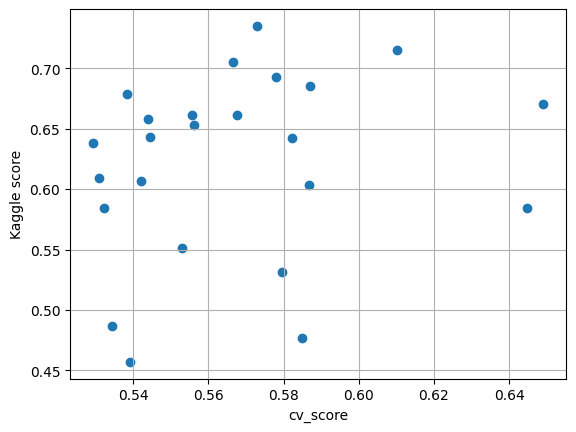

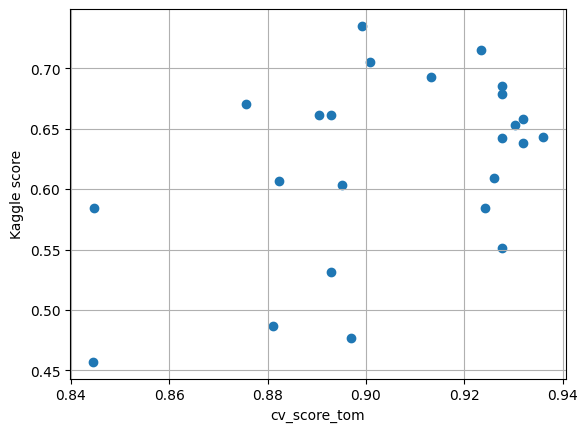

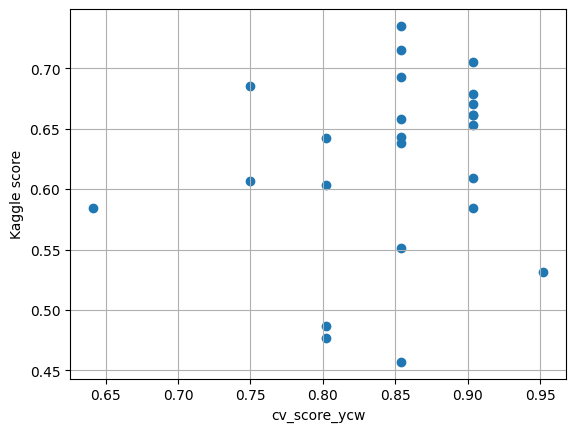

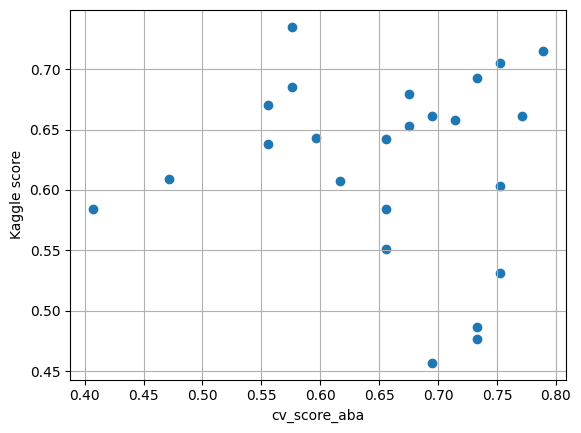

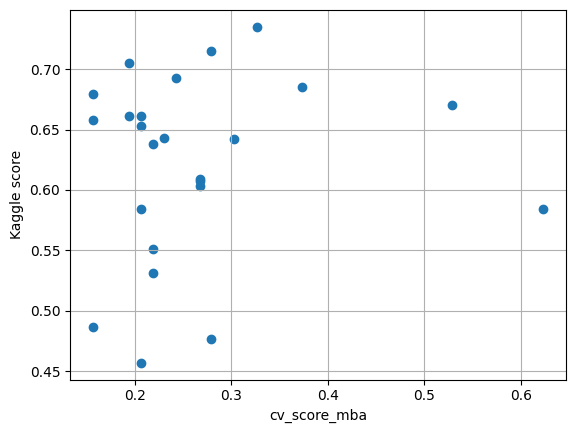

In [67]:
to_plot = copy.deepcopy(p).columns.to_list()[1:-9]
main = np.logical_and(np.logical_not(p['use_missing_value']), np.logical_not(p['cv_score']==-1.))
#print(main)
#print(p['model_name']=='yolov8m')
#main = p['tom']
for x_val in ['cv_score', 'cv_score_tom', 'cv_score_ycw', 'cv_score_aba', 'cv_score_mba']:
     plt.figure()
     plt.scatter(p[x_val][main], p['k_score'][main])
     plt.grid(True)
     plt.xlabel(x_val)
     plt.ylabel('Kaggle score')
to_plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline

todo = np.logical_and(main, np.logical_not(np.isnan(p['k_score'].to_numpy())))
y = p[['k_score']][todo]
X = p[['n_ensemble', 'scale_std_clip_value', 'blur_z', 'use_pretrained_weights', 'weight_decay', 'ycw', 'lr0_times_nepochs']][todo]
X['scale_std_clip_value2'] = X['scale_std_clip_value']**2
X['lr0_times_nepochs2'] = X['lr0_times_nepochs']**2
X = X[['lr0_times_nepochs', 'lr0_times_nepochs2', 'use_pretrained_weights']]

# Define candidate alphas (lambdas)
alphas = np.logspace(-4, 4, 10)

# Define pipeline explicitly with named steps
pipeline = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("ridge", sklearn.linear_model.Ridge())
])

# Define parameter grid (for Ridge alpha)
param_grid = {
    "ridge__alpha": alphas
}

# GridSearchCV with 5-fold cross-validation
grid_search = sklearn.model_selection.GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=10,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

# Fit GridSearchCV
grid_search.fit(X, y)

# Extract results
results = grid_search.cv_results_
mean_test_scores = -results['mean_test_score']  # Convert to positive MSE
alphas_tested = results['param_ridge__alpha'].data.astype(float)

# Plot CV error as function of alpha
plt.figure(figsize=(8, 6))
plt.semilogx(alphas_tested, mean_test_scores, marker='o')
plt.xlabel("Alpha (L2 Regularization Strength)")
plt.ylabel("Mean CV MSE")
plt.title("Cross-Validation Error vs Alpha")
plt.grid(True)
plt.show()

# Report best alpha
best_alpha = grid_search.best_params_['ridge__alpha']
print("Best alpha (lambda):", best_alpha)
print("Best CV Mean MSE:", -grid_search.best_score_)

# Create a new pipeline with the best alpha
final_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler()),
    ("lasso", sklearn.linear_model.Lasso(alpha=best_alpha))
])

# Fit to full dataset
final_model.fit(X, y)

y_pred = final_model.predict(X)
p['residual'] = np.nan
p.loc[todo,'residual'] = np.ravel(y)-y_pred

# (Optional) Print final coefficients and intercept
lasso_model = final_model.named_steps['lasso']
print("Final coefficients:", lasso_model.coef_)
print("Final intercept:", lasso_model.intercept_)

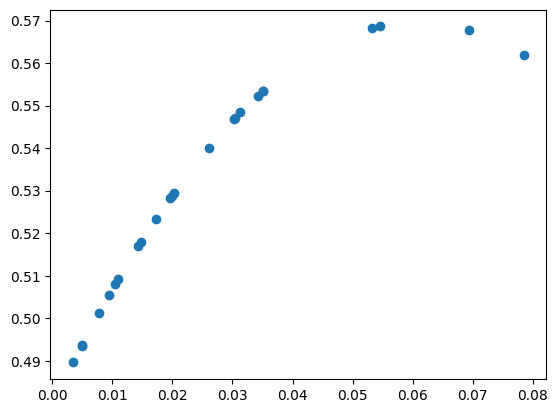

In [83]:
X_alt = copy.deepcopy(X)
for c in X_alt.columns:
    X_alt[c] = 0
X_alt['lr0_times_nepochs'] = X['lr0_times_nepochs']
X_alt['lr0_times_nepochs2'] = X['lr0_times_nepochs']**2
y_pred_alt = final_model.predict(X_alt)
plt.scatter(X_alt['lr0_times_nepochs'], y_pred_alt)

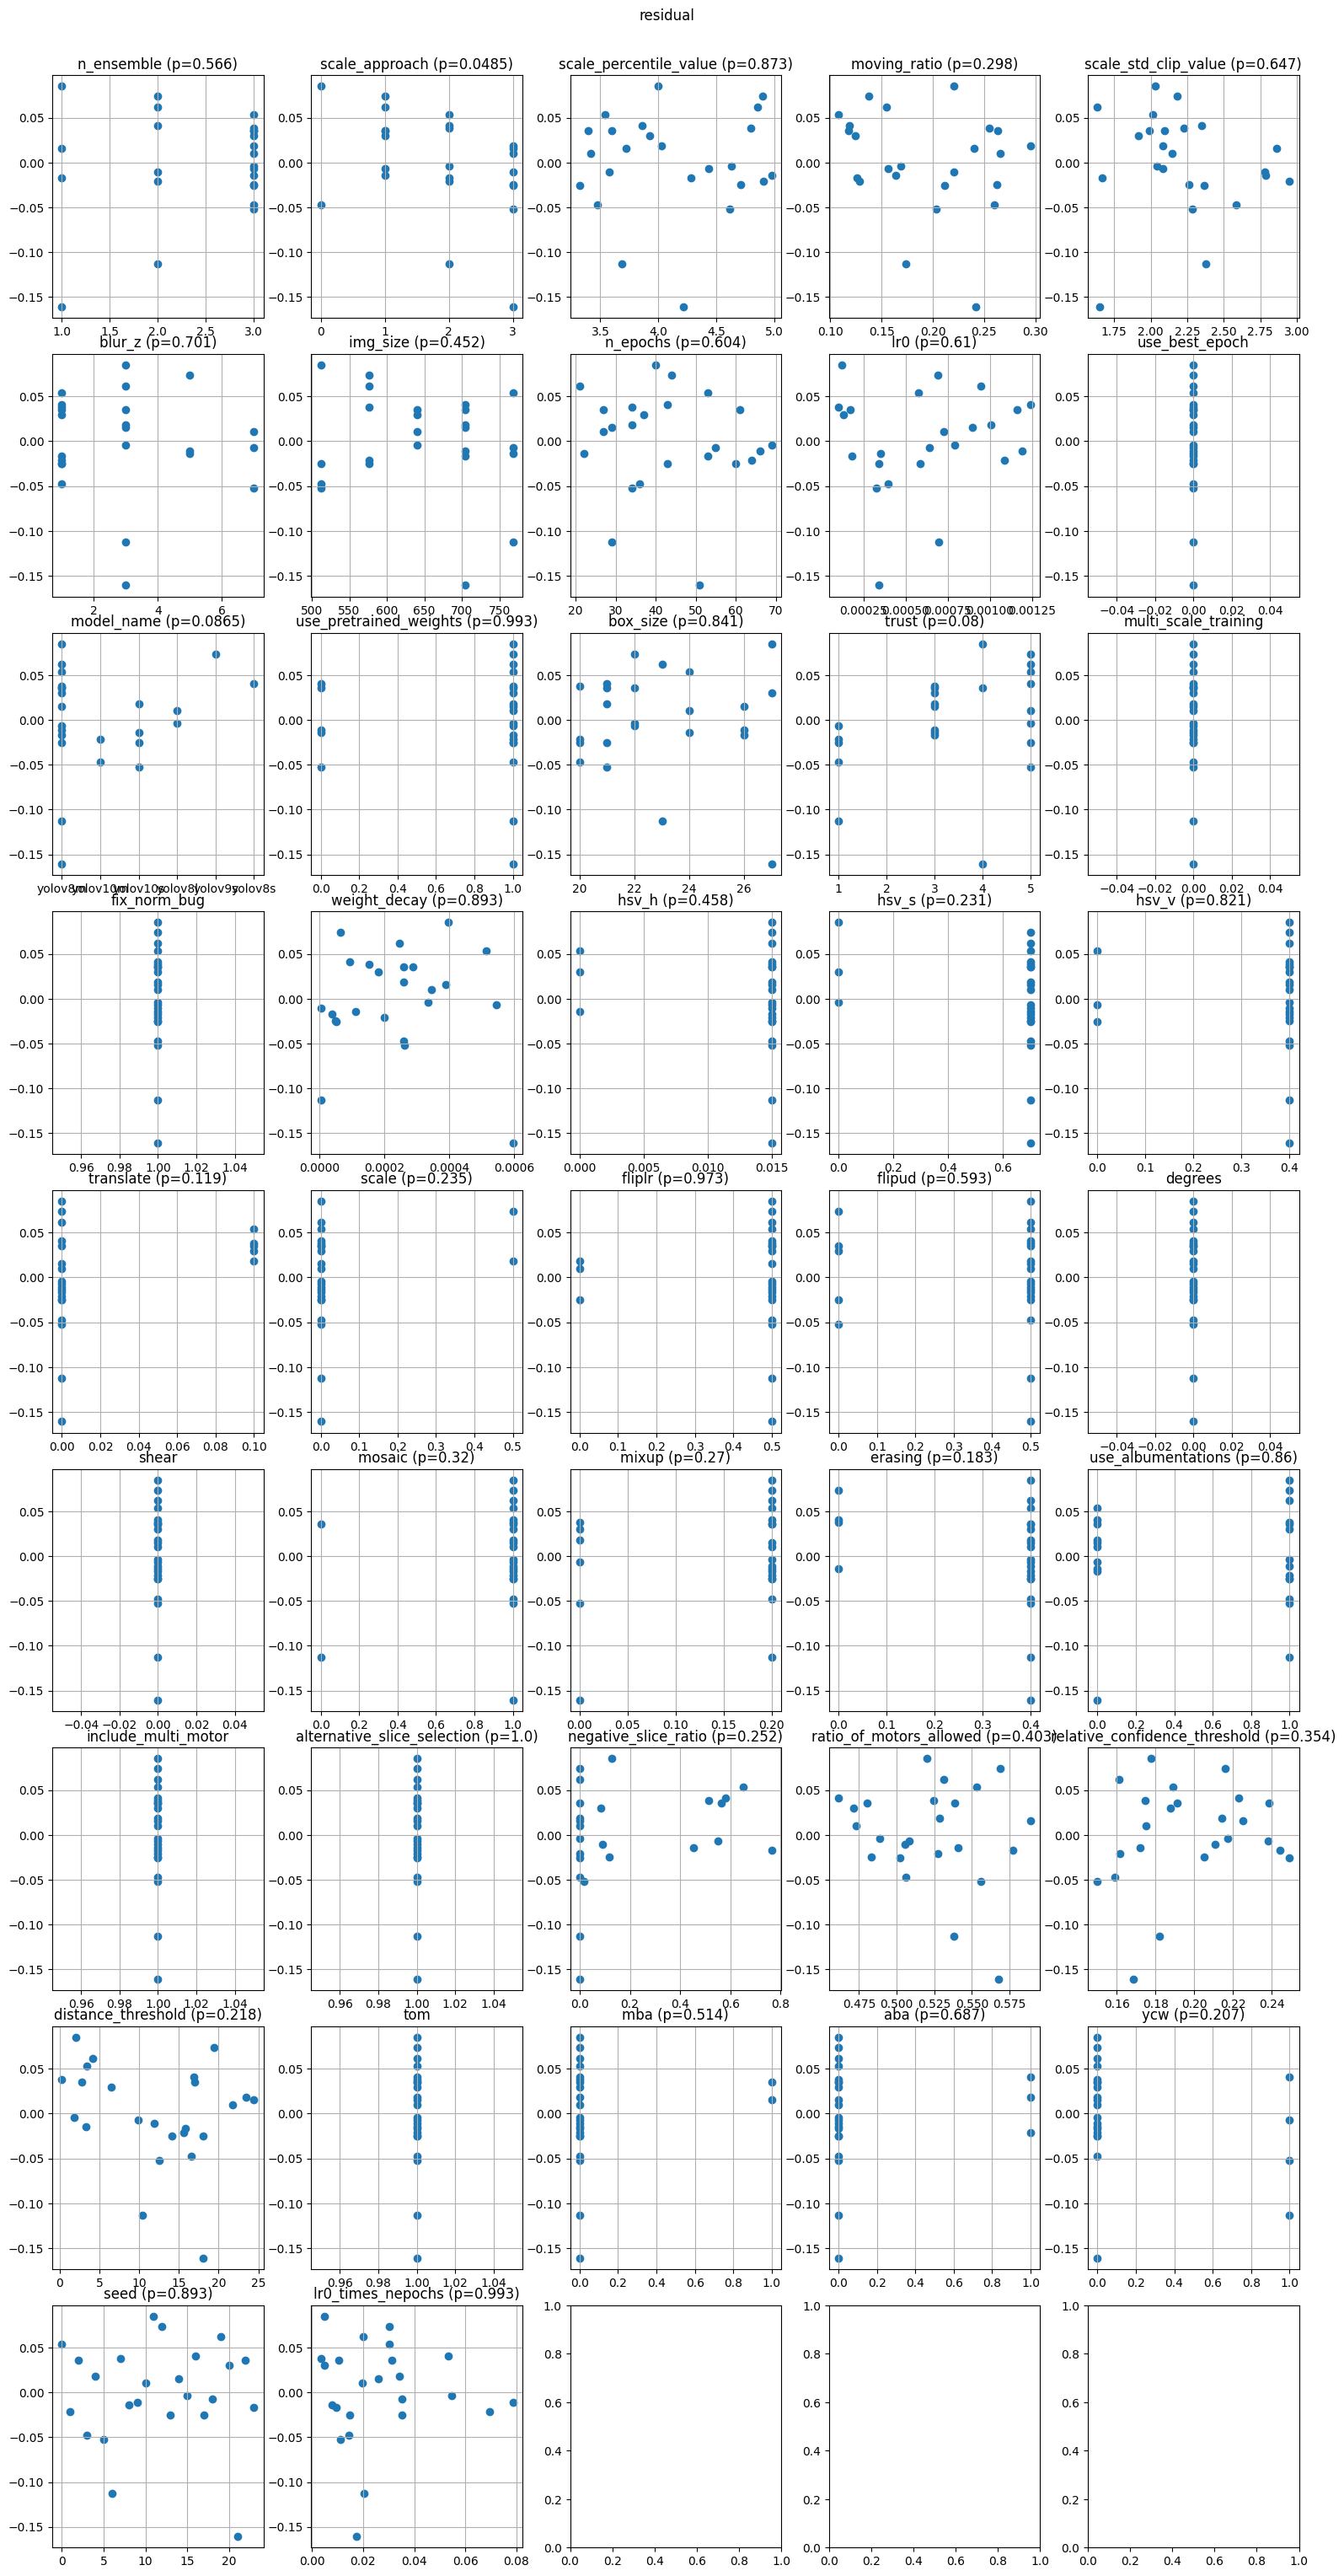

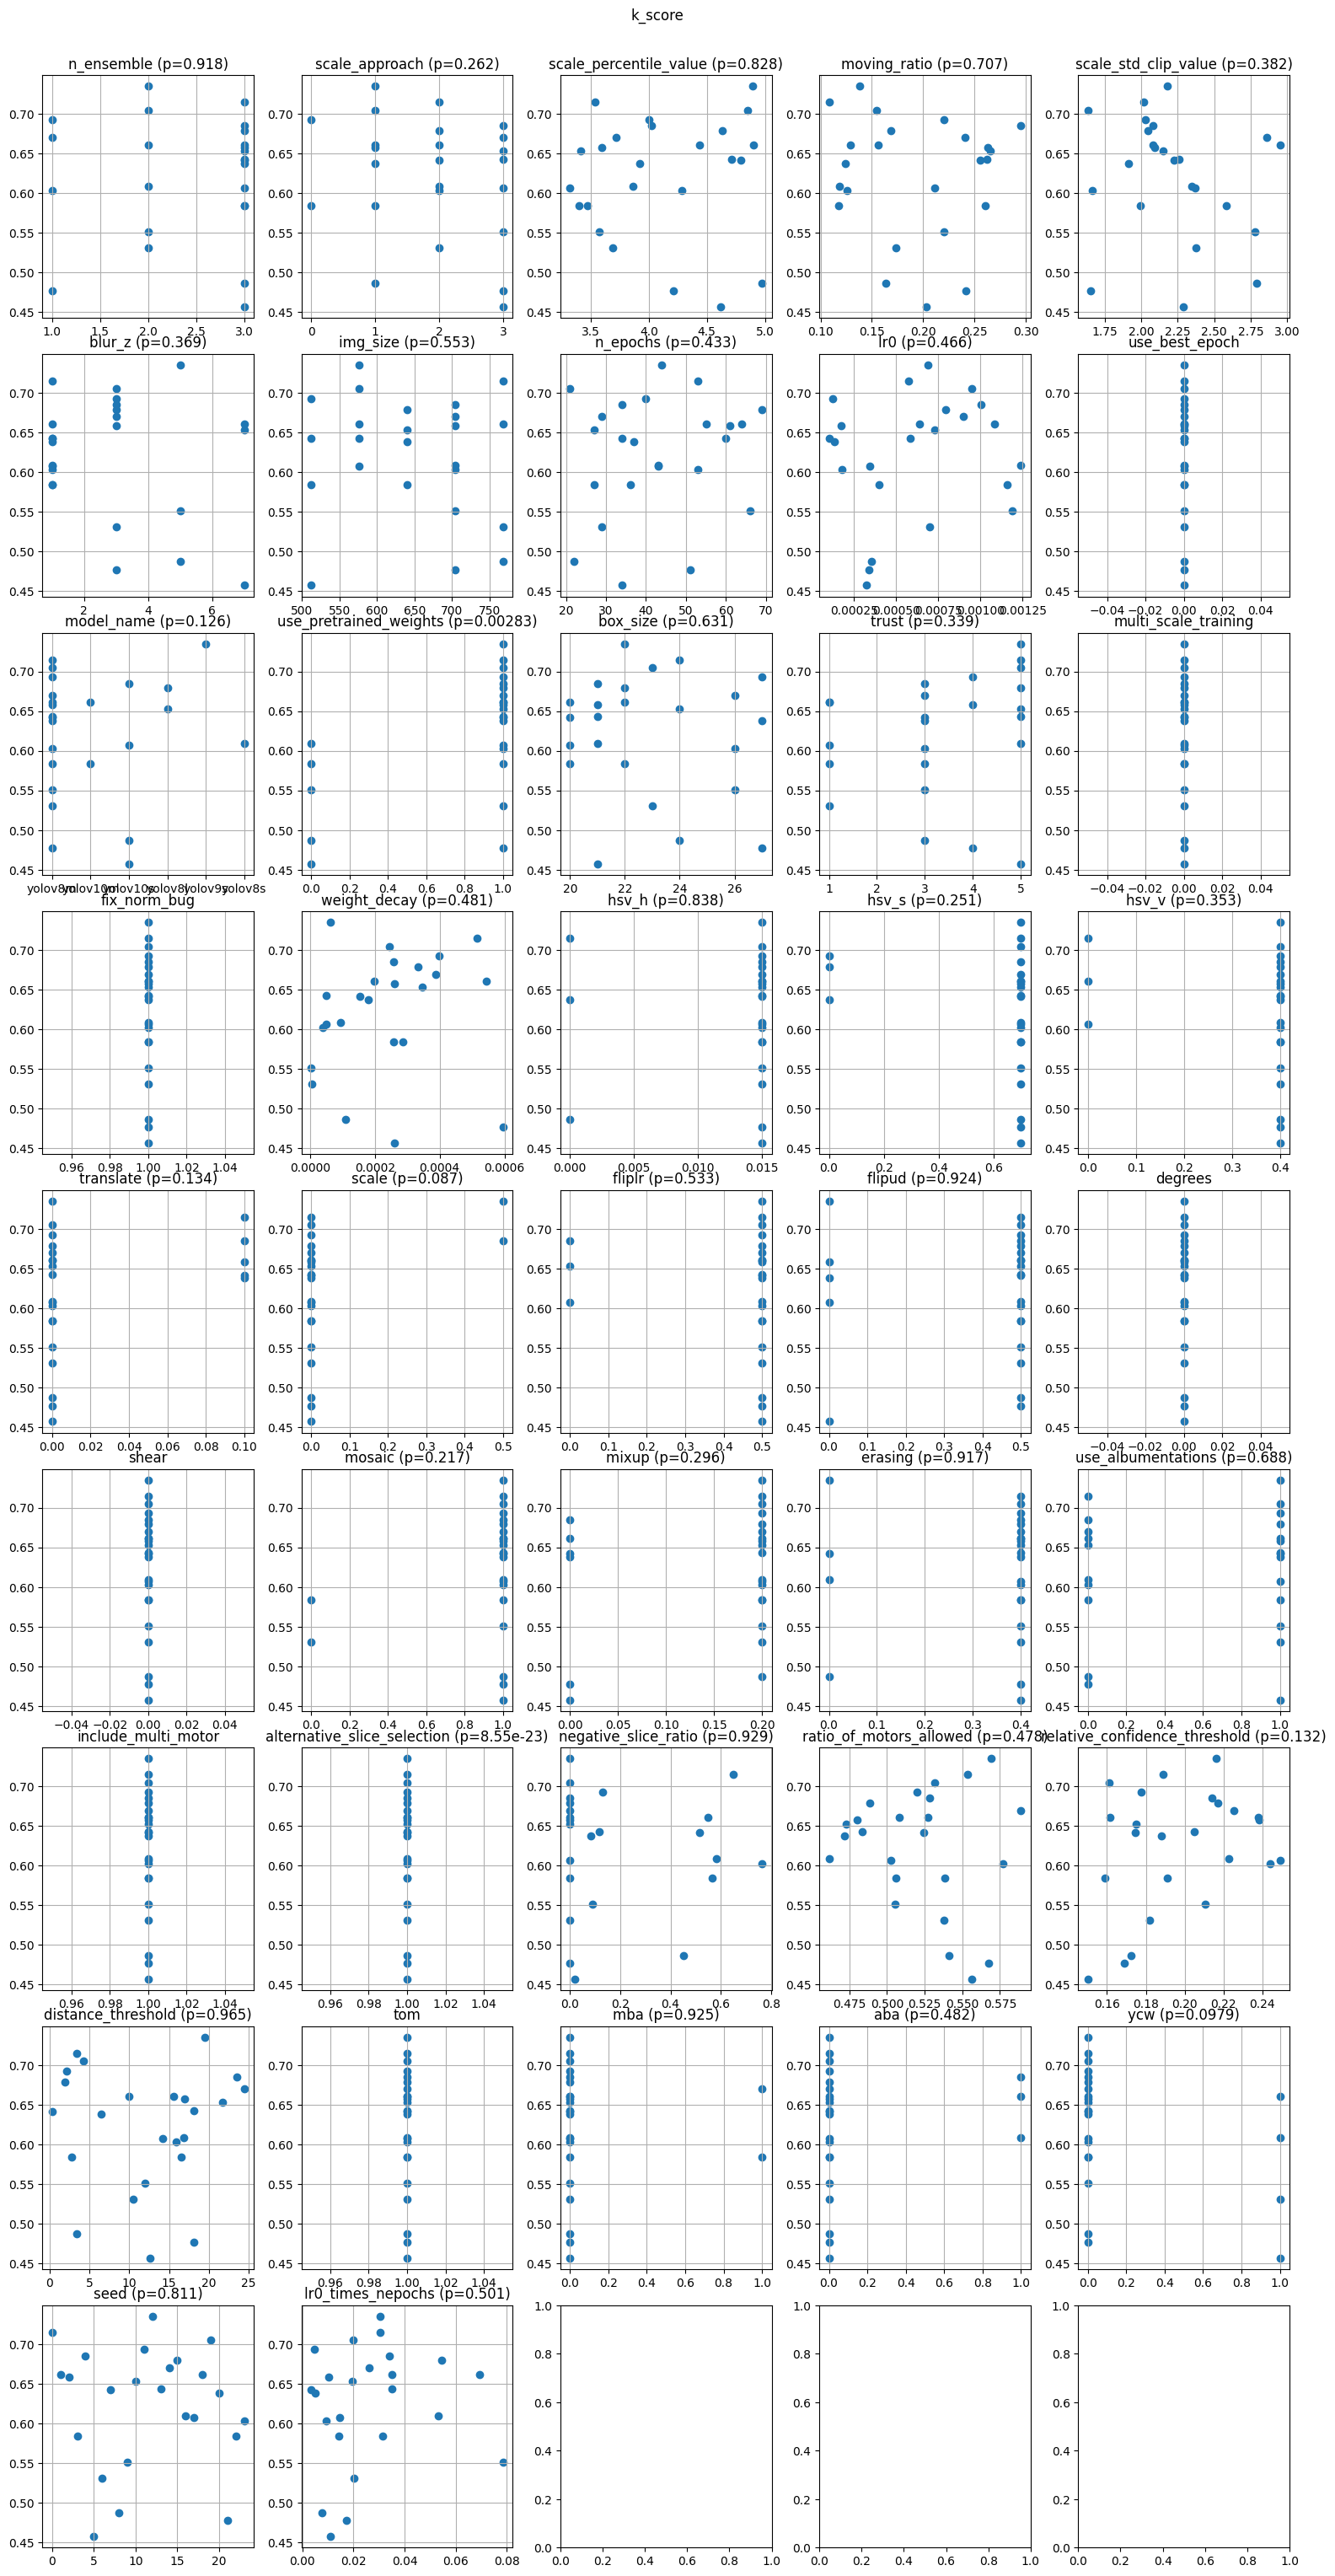

In [84]:
ncols = 5
nrows = len(to_plot)//ncols+1
figs = []
r = np.random.default_rng(seed=0)
for y_val in p.columns[-6:][[5,4]].to_list():
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18,18/ncols*nrows))
    plt.tight_layout(pad=10.0,h_pad=1,w_pad=1)
    figs.append(fig)
    plt.suptitle(y_val)
    for idx,d in enumerate(to_plot):
        row = idx // ncols
        col = idx % ncols
        ax = axes[row, col]
        plt.sca(ax)        
        plt.xlabel('')
        plt.ylabel('')
        plt.grid(True)
        #p[y_val] = r.normal(size=p[y_val].shape)
        plt.scatter(p[d][main], p[y_val][main])
        #if y_val == 'k_score':
         #   plt.scatter(p[d][np.logical_not(main)], p[y_val][np.logical_not(main)])
       
        # fit
        if len(np.unique(p[d][main]))>1:
            pp = copy.deepcopy(p)
            if not pd.api.types.is_numeric_dtype(pp[d]) or pd.api.types.is_bool_dtype(pp[d]):
                pp[d] = pp[d].astype('category').cat.codes
            X = pp[[d]][main]
            X['intercept'] = 1.
            y = p[y_val][main]
            to_keep = np.logical_not(np.isnan(y))
            X = X[to_keep]; y=y[to_keep];
            model = sm.OLS(y,X)
            results=model.fit()
            p_val = results.pvalues[d]
            plt.title(f'{d} (p={p_val:.3})')
        else:
            plt.title(d)
        
        # if d == 'mask_sizes0':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][0] for m in model_list]
        # elif d == 'mask_sizes1':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][1] for m in model_list]
        # elif d == 'mask_sizes2':
        #     x_vals = [m.mask_sizes[model.particles_to_do[0]][2] for m in model_list]
        # else:
        #     x_vals = [getattr(m, d)[model.particles_to_do[0]] for m in model_list]
        # if len(np.unique(x_vals))<8:
        #     #pass
        #     violin_plot(x_vals,score_vals)
        # else:
        #     plt.scatter(x_vals, score_vals)

In [11]:
# from pptx import Presentation
# from pptx.util import Inches

# prs = Presentation()
# blank = prs.slide_layouts[6]  # a blank slide layout

# for i, fig in enumerate(figs):
#     # save each figure to disk
#     img_path = f"figure_{i+1}.png"
#     fig.savefig(img_path, dpi=300, bbox_inches='tight')

#     # add a new slide, then add the image to it
#     slide = prs.slides.add_slide(blank)
#     slide.shapes.add_picture(
#         img_path,
#         Inches(1), Inches(1),          # left, top margins
#         width=Inches(8)                # scale width (height auto)
#     )

#     os.remove(img_path)

# prs.save("run_many_models_results.pptx")